<a href="https://colab.research.google.com/github/MariaTar7/educational-practice/blob/main/prediction_of_related_products.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Предсказание сопутствующих покупок 





#  Формулировка задачи

В датасете содержится информация о заказах с набором продуктов. Хоть в датасете и есть user_id, необходимо рассматривать каждую сессию как отдельного посетителя, информации о предыдущих заказов которого нет. Необходимо выдвинуть рекомендации для пользователя, основываясь на списке товаров, которые он уже выбрал в течение сессии, и  предсказать следующий товар в сессии. Такие системы называют Session Based Recommendation Systems. В этом ноутбуке я рассмотрела подход, основанный на Word2Vec, а также SR-GNN.

- https://github.com/userbehavioranalysis/SR-GNN_PyTorch-Geometric

#  Библиотеки

In [ ]:
!pip install implicit

In [ ]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

RuntimeError: ignored

In [ ]:
# Import Python built-in libraries
import copy
import pickle
import random
import time

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm, trange


In [ ]:
# Import pip libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

# Import torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

# Import PyG packages
import torch_geometric as pyg
import torch_geometric.data as pyg_data
from torch_geometric.typing import Adj, OptTensor
import torch_sparse

#  Data Preprocessing

## Загрузка



In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

--2022-08-31 05:08:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23715344 (23M) [application/x-httpd-php]
Saving to: ‘Online Retail.xlsx’

Online Retail.xlsx  100%[===================>]  22.62M  23.3MB/s    in 1.0s    

2022-08-31 05:09:00 (23.3 MB/s) - ‘Online Retail.xlsx’ saved [23715344/23715344]



In [ ]:
events_df = pd.read_excel('Online Retail.xlsx')
print(events_df.head())
print(f'There are {len(events_df)} rows in the raw data.')

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
There are 541909 rows in the raw data.


- InvoiceNo - id сессии (заказа)
- StockCode - id товара
- Description - описание товара
- InvoiceDate - дата выполнения заказа


In [ ]:
events_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [ ]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
events_df['StockCode'] = events_df['StockCode'].astype(str).str.replace(r'\D', '')
events_df = events_df[events_df['StockCode'] != '']
events_df['StockCode'] = events_df['StockCode'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
#для ворд2века
events_df['StockCode'] = events_df['StockCode'].astype(str)

In [ ]:
events_df['InvoiceNo'] = events_df['InvoiceNo'].astype(str).str.replace(r'\D', '')
events_df = events_df[events_df['InvoiceNo'] != '']
events_df['InvoiceNo'] = events_df['InvoiceNo'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
events_df_filtered = events_df

In [ ]:
# отфильтровываем, смотрим, чтоб были только сессии как минимум с 2 товарами
visit_counts_per_visitor = events_df_filtered['InvoiceNo'].value_counts(dropna=False)
visit_counts_per_visitor.head()

visitors_with_significant_visits = visit_counts_per_visitor[
    visit_counts_per_visitor > 1
].index
events_df_filtered = events_df_filtered[
    events_df_filtered['InvoiceNo'].isin(visitors_with_significant_visits)]

In [ ]:
visits_by_visitors = {} 
for _, row in enumerate(tqdm(events_df_filtered.iterrows())):
    InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country = row[1].values

    if InvoiceNo not in visits_by_visitors:
        visits_by_visitors[InvoiceNo] = {'itemids': [], 'timestamps': []}
    visits_by_visitors[InvoiceNo]['itemids'].append(StockCode)
    visits_by_visitors[InvoiceNo]['timestamps'].append(InvoiceDate)

print()
print(f'There are {len(visits_by_visitors)} visitors left.')

536068it [00:25, 20925.37it/s]


There are 20059 visitors left.


In [ ]:
sessions_by_visitors = {}
for _, row in enumerate(tqdm(events_df_filtered.iterrows())):
    InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country = row[1].values

    if InvoiceNo not in sessions_by_visitors:
        sessions_by_visitors[InvoiceNo] = [[]]
    sessions_by_visitors[InvoiceNo][-1].append(StockCode)
#visitor_dict['StockCodes'] = [visitor_dict['StockCodes'][:-1], [visitor_dict['StockCodes'][-1]]]

 

536068it [00:25, 21258.17it/s]


In [ ]:
events_df.describe()

,InvoiceNo,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,541909.000000,406829.000000
mean,559946.967325,9.552250,4.611114,15287.690570
std,13421.287454,218.081158,96.759853,1713.600303
min,536365.000000,-80995.000000,-11062.060000,12346.000000
25%,547896.000000,1.000000,1.250000,13953.000000
50%,560601.000000,3.000000,2.080000,15152.000000
75%,571779.000000,10.000000,4.130000,16791.000000
max,581587.000000,80995.000000,38970.000000,18287.000000


## Разделим датасет на обучающую и тестовую выборки

Делим датасет по id

In [ ]:
# Adjsut sampling rate ([0, 1]) to generate smaller datasets.
# Setting `sampling_rate` to 1 will lead to a full dataset split.
import random
sampling_rate = 1

# We use random seed for reproducibility.
seed = 42
all_visitors = list(sessions_by_visitors.keys())
random.Random(seed).shuffle(all_visitors)

num_train = int(len(all_visitors) * 0.8 * sampling_rate)
num_val = int(len(all_visitors) * 0.1 * sampling_rate)
num_test = int(len(all_visitors) * 0.1 * sampling_rate)

train_visitors = all_visitors[:num_train]
val_visitors = all_visitors[num_train : num_train+num_val]
test_visitors = all_visitors[num_train+num_val:num_train+num_val+num_test]

In [ ]:
all_train_visitors = (train_visitors + val_visitors)

# Word2vec

Идея следующая:как при применении в текстах с помощью word2vec можно искать ближайшие токены вокруг, в нашем случае будет анализироватся контекст внутри сессий.

In [ ]:
#hide
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [ ]:
test_w2v = events_df[events_df['InvoiceNo'].isin(test_visitors)] # тест
train_w2v = events_df[events_df['InvoiceNo'].isin(all_train_visitors)] # трейн

In [ ]:
# список сессий с товарами в трейне
purchases_train = []

for i in tqdm(all_train_visitors):
    temp = train_w2v[train_w2v["InvoiceNo"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 18052/18052 [00:16<00:00, 1069.40it/s]


In [ ]:
# список сессий с товарами в тесте

purchases_test = []

for i in tqdm(test_visitors):
    temp = test_w2v[test_w2v["InvoiceNo"] == i]["StockCode"].tolist()
    purchases_test.append(temp)

100%|██████████| 2005/2005 [00:01<00:00, 1925.08it/s]


In [ ]:
# обучаем word2vec модель
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(4789309, 4819620)

In [ ]:
model.save("word2vec_2.model")

In [ ]:
model.init_sims(replace=True)

In [ ]:
print(model)

Word2Vec(vocab=3438, size=100, alpha=0.03)


In [ ]:
X = model[model.wv.vocab]

X.shape

(3438, 100)

In [ ]:
# Визуализация
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 7.0 MB/s 
     |████████████████████████████████| 1.1 MB 56.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=5911ff6c948d1cc80cc30f2a2af6fbe2e6ef899c229bc495bd4f88278c74cfa6
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=0b9703303fa65624e72a48e1fee5b486cde49854eca5994049e077b8504db276
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


Каждая точка обозначает товар. Мы можем видеть, что образуются группы похожих товаров

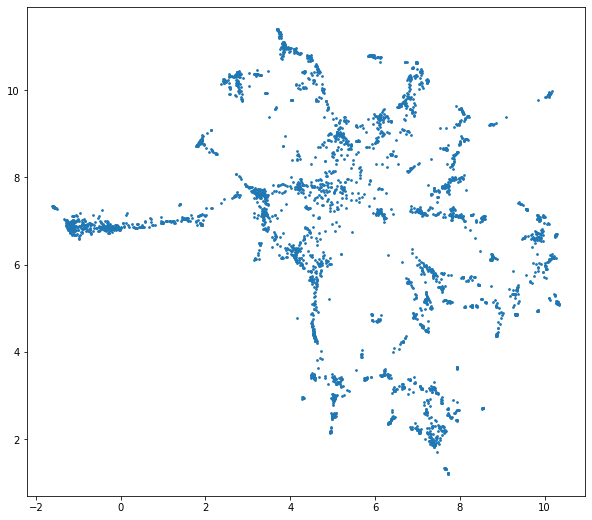

In [ ]:
# Можем наблюдать кластеры
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral');

In [ ]:
products = train_w2v[["StockCode", "Description"]]

# убираем дубликаты
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# создали StockCode и Description словарь
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [ ]:
products_dict

{'10002': ['INFLATABLE POLITICAL GLOBE '],
 '10080': ['GROOVY CACTUS INFLATABLE'],
 '10120': ['DOGGY RUBBER'],
 '10123C': ['HEARTS WRAPPING TAPE '],
 '10124A': ['SPOTS ON RED BOOKCOVER TAPE'],
 '10124G': ['ARMY CAMO BOOKCOVER TAPE'],
 '10125': ['MINI FUNKY DESIGN TAPES'],
 '10133': ['COLOURING PENCILS BROWN TUBE'],
 '10135': ['COLOURING PENCILS BROWN TUBE'],
 '11001': ['ASSTD DESIGN RACING CAR PEN'],
 '15030': ['FAN BLACK FRAME '],
 '15034': ['PAPER POCKET TRAVELING FAN '],
 '15036': ['ASSORTED COLOURS SILK FAN'],
 '15039': ['SANDALWOOD FAN'],
 '15044A': ['PINK PAPER PARASOL '],
 '15044B': ['BLUE PAPER PARASOL '],
 '15044C': ['PURPLE PAPER PARASOL'],
 '15044D': ['RED PAPER PARASOL'],
 '15056BL': ['EDWARDIAN PARASOL BLACK'],
 '15056N': ['EDWARDIAN PARASOL NATURAL'],
 '15056P': ['EDWARDIAN PARASOL PINK'],
 '15056bl': ['EDWARDIAN PARASOL BLACK'],
 '15056n': ['EDWARDIAN PARASOL NATURAL'],
 '15056p': ['EDWARDIAN PARASOL PINK'],
 '15058A': ['BLUE POLKADOT GARDEN PARASOL'],
 '15058B': ['PINK 

In [ ]:
# функция для нахождения схожих товаров
def similar_products(v, n = 20):
    
    # определение n похожих товаров
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # подсчет скора, показывающего схожесть товаров
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms  

In [ ]:
test_w2v

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
155,536384,82484,WOOD BLACK BOARD ANT WHITE FINISH,3,2010-12-01 09:53:00,6.45,18074.0,United Kingdom
156,536384,84755,COLOUR GLASS T-LIGHT HOLDER HANGING,48,2010-12-01 09:53:00,0.65,18074.0,United Kingdom
157,536384,22464,HANGING METAL HEART LANTERN,12,2010-12-01 09:53:00,1.65,18074.0,United Kingdom
158,536384,21324,HANGING MEDINA LANTERN SMALL,6,2010-12-01 09:53:00,2.95,18074.0,United Kingdom
159,536384,22457,NATURAL SLATE HEART CHALKBOARD,12,2010-12-01 09:53:00,2.95,18074.0,United Kingdom
...,...,...,...,...,...,...,...,...
539176,581436,22726,ALARM CLOCK BAKELIKE GREEN,4,2011-12-08 16:18:00,3.75,17491.0,United Kingdom
539177,581436,23428,IVORY RETRO KITCHEN WALL CLOCK,4,2011-12-08 16:18:00,8.15,17491.0,United Kingdom
539178,581436,22087,PAPER BUNTING WHITE LACE,24,2011-12-08 16:18:00,2.95,17491.0,United Kingdom
541867,581584,20832,RED FLOCK LOVE HEART PHOTO FRAME,72,2011-12-09 12:25:00,0.72,13777.0,United Kingdom


In [ ]:
products_dict['82484'] # взяли товар из теста и нашли 5 похожих 

['WOOD BLACK BOARD ANT WHITE FINISH']

In [ ]:
similar_products(model['82484'], n = 5)

[('3 DRAWER ANTIQUE WHITE WOOD CABINET', 0.7486175298690796),
 ('WOODEN FRAME ANTIQUE WHITE ', 0.7065954208374023),
 ('WOODEN PICTURE FRAME WHITE FINISH', 0.6957124471664429),
 ('WOOD 2 DRAWER CABINET WHITE FINISH', 0.6899396181106567),
 ('WHITE MOROCCAN METAL LANTERN', 0.6240553855895996),
 ('LARGE ZINC GLASS CANDLEHOLDER', 0.6055361032485962)]

In [ ]:
#Агрегирование векторов ВСЕХ продуктов из сессии в тесте, чтобы искать товары, похожие на всю сессию, а не на конкретный товар из нее
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [ ]:
#hide
aggregate_vectors(purchases_test[0]).shape

(100,)

30 рекомендаций следующего элемента в 11ой сессии, учитывая каждый продукт в ней

In [ ]:
similar_products(aggregate_vectors(purchases_test[11][:-1]), n = 30)  

[('LUNCH BAG PINK POLKADOT', 0.6659675240516663),
 ('LUNCH BAG ALPHABET DESIGN', 0.6619971394538879),
 ('LUNCH BAG VINTAGE DOILY ', 0.6556226015090942),
 ('LUNCH BAG VINTAGE LEAF DESIGN', 0.6515102386474609),
 ('LUNCH BAG RED RETROSPOT', 0.650903582572937),
 ('LUNCH BAG CARS BLUE', 0.6505046486854553),
 ('JUMBO BAG VINTAGE LEAF', 0.6427484750747681),
 ('LUNCH BAG APPLE DESIGN', 0.641869068145752),
 ('JUMBO BAG VINTAGE DOILY ', 0.6415612697601318),
 ('LUNCH BAG SPACEBOY DESIGN ', 0.6355056166648865),
 ('LUNCH BAG DOLLY GIRL DESIGN', 0.6307656764984131),
 ('LUNCH BAG SUKI DESIGN ', 0.626299262046814),
 ('JUMBO BAG PEARS', 0.6239145994186401),
 ('RED RETROSPOT SHOPPER BAG', 0.6230721473693848),
 ('LUNCH BAG WOODLAND', 0.6226812601089478),
 ('LILAC GAUZE BUTTERFLY LAMPSHADE', 0.6173720359802246),
 ('JUMBO BAG ALPHABET', 0.6119866967201233),
 ('JUMBO BAG APPLES', 0.610069751739502),
 ('JUMBO STORAGE BAG SKULLS', 0.5997438430786133),
 ('ORANGE SCENTED SET/9 T-LIGHTS', 0.594342827796936),
 ('

Состав 11 сессии. Как видим предсказания релевантны, похожи на состав сессии

In [ ]:

for item in purchases_test[11]:
    print(item, products_dict[item])

90148 ['LONG SILVER NECKLACE PASTEL FLOWER']
90124C ['GREEN MURANO TWIST NECKLACE']
90206C ['CRYSTAL DIAMANTE STAR BROOCH']
90184B ['AMETHYST CHUNKY BEAD BRACELET W STR']
90081C ['LILY BROOCH OLIVE COLOUR']
90081A ['LILY BROOCH AMETHYST COLOUR']
90030C ['BROWN KUKUI COCONUT SEED NECKLACE']
84997B ['CHILDRENS CUTLERY RETROSPOT RED ']
84997C ['CHILDRENS CUTLERY POLKADOT BLUE']
84997D ['CHILDRENS CUTLERY POLKADOT PINK']
23256 ['CHILDRENS CUTLERY SPACEBOY ']
23343 ['JUMBO BAG VINTAGE CHRISTMAS ']
21584 ['RETROSPOT SMALL TUBE MATCHES']
22411 ['JUMBO SHOPPER VINTAGE RED PAISLEY']
21929 ['JUMBO BAG PINK VINTAGE PAISLEY']
22776 ['SWEETHEART 3 TIER CAKE STAND ']
82582 ['AREA PATROLLED METAL SIGN']
21165 ['BEWARE OF THE CAT METAL SIGN ']
21164 ['HOME SWEET HOME METAL SIGN ']
82552 ['WASHROOM METAL SIGN']
82551 ['LAUNDRY 15C METAL SIGN']
21175 ['GIN AND TONIC DIET METAL SIGN']
21174 ['POTTERING IN THE SHED METAL SIGN']
22413 ['METAL SIGN TAKE IT OR LEAVE IT ']
22675 ['FRENCH KITCHEN SIGN BLUE MET

Однако, сам последний элемент модель не смогла угадать

In [ ]:
products_dict[purchases_test[11][-1]]

['BLACK/BLUE POLKADOT UMBRELLA']

# SR-GNN


Классическая графовая нейронная сеть для задачи Session Based Recommendations. 
Каждая сессия представляется в виде графа, а товар - в виде узла.

## Препроцессинг

In [ ]:
all_train_visitors = (train_visitors + val_visitors)

In [ ]:
def extract_subsessions(sessions):
    """Extracts all partial sessions from the sessions given.

    For example, a session (1, 2, 3) should be augemnted to produce two
    separate sessions (1, 2) and (1, 2, 3).
    """
    all_sessions = []
    for session in sessions:
        for i in range(1, len(session)):
            all_sessions.append(session[:i+1])
    return all_sessions

In [ ]:

print(f'train, val, and test visitors: {len(train_visitors), len(val_visitors), len(test_visitors)}')

# Get sessions of each visitor, generate subsessions of each session, and put
# all the generated subsessions into right splits. We generate subsessions
# according to the dataset generation policy suggested by the original SR-GNN
# paper.
train_sessions, val_sessions, test_sessions = [], [], []
for visitor in train_visitors:
    train_sessions.extend(extract_subsessions(sessions_by_visitors[visitor]))
for visitor in val_visitors:
    val_sessions.extend(extract_subsessions(sessions_by_visitors[visitor]))
for visitor in test_visitors:
    test_sessions.extend(extract_subsessions(sessions_by_visitors[visitor]))

train, val, and test visitors: (15937, 1992, 1992)


In [ ]:
mkdir "raw"

mkdir: cannot create directory ‘raw’: File exists


In [ ]:
# Check the number of (sub)sessions in each split
print(f'train, val, and test sessions: {len(train_sessions), len(val_sessions), len(test_sessions)}')

# Save the processed files.
with open('raw/train.txt', 'wb') as f:
    pickle.dump(train_sessions, f)
with open('raw/val.txt', 'wb') as f:
    pickle.dump(val_sessions, f)
with open('raw/test.txt', 'wb') as f:
    pickle.dump(test_sessions, f)

train, val, and test sessions: (410911, 52189, 50704)


##  Data Pipeline

Используем PyTorch's `dataloader` и PyG's `Data` class. 
[документация](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#module-torch_geometric.data).

In [ ]:
class GraphDataset(pyg_data.InMemoryDataset):
    def __init__(self, root, file_name, transform=None, pre_transform=None):
        self.file_name = file_name
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [f'{self.file_name}.txt']

    @property
    def processed_file_names(self):
        return [f'{self.file_name}.pt']

    def download(self):
        pass

    def process(self):
        raw_data_file = f'{self.raw_dir}/{self.raw_file_names[0]}'
        with open(raw_data_file, 'rb') as f:
            sessions = pickle.load(f)
        data_list = []

        for session in sessions:
            session, y = session[:-1], session[-1]
            codes, uniques = pd.factorize(session)
            senders, receivers = codes[:-1], codes[1:]

            # Build Data instance
            edge_index = torch.tensor([senders, receivers], dtype=torch.long)
            x = torch.tensor(uniques, dtype=torch.long).unsqueeze(1)
            y = torch.tensor([y], dtype=torch.long)
            data_list.append(pyg_data.Data(x=x, edge_index=edge_index, y=y))

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

## Моделируем модель



In [ ]:
class GatedSessionGraphConv(pyg.nn.conv.MessagePassing):
    def __init__(self, out_channels, aggr: str = 'add', **kwargs):
        super().__init__(aggr=aggr, **kwargs)

        self.out_channels = out_channels

        self.gru = torch.nn.GRUCell(out_channels, out_channels, bias=False)

    def forward(self, x, edge_index):
        m = self.propagate(edge_index, x=x, size=None)
        x = self.gru(m, x)
        return x

    def message(self, x_j):
        return x_j

    def message_and_aggregate(self, adj_t, x):
        return matmul(adj_t, x, reduce=self.aggr)

In [ ]:
class SRGNN(nn.Module):
    def __init__(self, hidden_size, n_items):
        super(SRGNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_items = n_items

        self.embedding = nn.Embedding(self.n_items, self.hidden_size)
        self.gated = GatedSessionGraphConv(self.hidden_size)

        self.q = nn.Linear(self.hidden_size, 1)
        self.W_1 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.W_2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.W_3 = nn.Linear(2 * self.hidden_size, self.hidden_size, bias=False)

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, data):
        x, edge_index, batch_map = data.x, data.edge_index, data.batch

        # (0)
        embedding = self.embedding(x).squeeze()

        # (1)-(5)
        v_i = self.gated(embedding, edge_index)

        # Divide nodes by session
        # For the detailed explanation of what is happening below, please refer
        # to the Medium blog post.
        sections = list(torch.bincount(batch_map).cpu())
        v_i_split = torch.split(v_i, sections)

        v_n, v_n_repeat = [], []
        for session in v_i_split:
            v_n.append(session[-1])
            v_n_repeat.append(
                session[-1].view(1, -1).repeat(session.shape[0], 1))
        v_n, v_n_repeat = torch.stack(v_n), torch.cat(v_n_repeat, dim=0)

        q1 = self.W_1(v_n_repeat)
        q2 = self.W_2(v_i)

        # (6)
        alpha = self.q(F.sigmoid(q1 + q2))
        s_g_split = torch.split(alpha * v_i, sections)

        s_g = []
        for session in s_g_split:
            s_g_session = torch.sum(session, dim=0)
            s_g.append(s_g_session)
        s_g = torch.stack(s_g)

        # (7)
        s_l = v_n
        s_h = self.W_3(torch.cat([s_l, s_g], dim=-1))

        # (8)
        z = torch.mm(self.embedding.weight, s_h.T).T
        return z

## Обучение модели


In [ ]:
max(events_df['StockCode'])

90214

In [ ]:
# Гиперпараметры
args = {
    'batch_size': 100,
    'hidden_dim': 32,
    'epochs': 50,
    'l2_penalty': 0.00001,
    'weight_decay': 0.1,
    'step': 30,
    'lr': 0.001,
    'num_items': 90215} 

class objectview(object):
    def __init__(self, d): 
        self.__dict__ = d

args = objectview(args)

In [ ]:
def train(args):
    # Prepare data pipeline
    train_dataset = GraphDataset('./', 'train')
    train_loader = pyg_data.DataLoader(train_dataset,
                                       batch_size=args.batch_size,
                                       shuffle=False,
                                       drop_last=True)
    val_dataset = GraphDataset('./', 'val')
    val_loader = pyg_data.DataLoader(val_dataset,
                                     batch_size=args.batch_size,
                                     shuffle=False,
                                     drop_last=True)

    # Build model
    model = SRGNN(args.hidden_dim, args.num_items).to('cuda')

    # Get training components
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=args.lr,
                                 weight_decay=args.l2_penalty)
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step,
                                          gamma=args.weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Train
    losses = []
    test_accs = []
    top_k_accs = []

    best_acc = 0
    best_model = None

    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for _, batch in enumerate(tqdm(train_loader)):
            batch.to('cuda')
            optimizer.zero_grad()

            pred = model(batch)
            label = batch.y
            loss = criterion(pred, label)

            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs

        total_loss /= len(train_loader.dataset)
        losses.append(total_loss)

        scheduler.step()

        if epoch % 1 == 0:
          test_acc, top_k_acc = test(val_loader, model, is_validation=True)
          print(test_acc)
          test_accs.append(test_acc)
          top_k_accs.append(top_k_acc)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])
  
    return test_accs, top_k_accs, losses, best_model, best_acc, val_loader

In [ ]:
def test(loader, test_model, is_validation=False, save_model_preds=False):
    test_model.eval()

    # Define K for Hit@K metrics.
    k = 20
    correct = 0
    top_k_correct = 0

    for _, data in enumerate(tqdm(loader)):
        data.to('cuda')
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            score = test_model(data)
            pred = score.max(dim=1)[1]
            label = data.y

        if save_model_preds:
          data = {}
          data['pred'] = pred.view(-1).cpu().detach().numpy()
          data['label'] = label.view(-1).cpu().detach().numpy()

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('pred.csv', sep=',', index=False)
            
        correct += pred.eq(label).sum().item()

        
        if not is_validation:
            score = score.cpu().detach().numpy()
            for row in range(pred.size(0)):
                top_k_pred = np.argpartition(score[row], -k)[-k:]
                if label[row].item() in top_k_pred:
                    top_k_correct += 1
    
    if not is_validation:
        return correct / len(loader), top_k_correct / len(loader)
    else:
        return correct / len(loader), 0

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
  0%|          | 0/4109 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 521/521 [00:10<00:00, 49.60it/s]


2.0


100%|██████████| 521/521 [00:05<00:00, 92.05it/s]


3.6468330134357005


100%|██████████| 521/521 [00:05<00:00, 92.26it/s]


5.092130518234165


100%|██████████| 521/521 [00:05<00:00, 92.20it/s]


6.245681381957773


100%|██████████| 521/521 [00:06<00:00, 79.00it/s]


7.401151631477927


100%|██████████| 521/521 [00:05<00:00, 91.44it/s]


8.12092130518234


100%|██████████| 521/521 [00:05<00:00, 90.21it/s]


8.742802303262955


100%|██████████| 521/521 [00:05<00:00, 91.67it/s]


9.422264875239923


100%|██████████| 521/521 [00:07<00:00, 69.75it/s]


9.932821497120921


100%|██████████| 521/521 [00:05<00:00, 91.43it/s]


10.418426103646834


100%|██████████| 521/521 [00:06<00:00, 79.50it/s]


11.001919385796546


100%|██████████| 521/521 [00:05<00:00, 90.67it/s]


11.353166986564299


100%|██████████| 521/521 [00:05<00:00, 91.43it/s]


11.614203454894433


100%|██████████| 521/521 [00:05<00:00, 91.49it/s]


11.84644913627639


100%|██████████| 521/521 [00:05<00:00, 90.69it/s]


12.067178502879079


100%|██████████| 521/521 [00:06<00:00, 78.99it/s]


12.285988483685221


100%|██████████| 521/521 [00:05<00:00, 89.17it/s]


12.412667946257198


100%|██████████| 521/521 [00:05<00:00, 89.70it/s]


12.564299424184261


100%|██████████| 521/521 [00:05<00:00, 90.57it/s]


12.723608445297504


100%|██████████| 521/521 [00:05<00:00, 90.60it/s]


12.873320537428024


100%|██████████| 521/521 [00:05<00:00, 90.10it/s]


12.940499040307103


100%|██████████| 521/521 [00:05<00:00, 90.47it/s]


13.028790786948177


100%|██████████| 521/521 [00:07<00:00, 70.70it/s]


13.159309021113243


100%|██████████| 521/521 [00:05<00:00, 91.36it/s]


13.287907869481765


100%|██████████| 521/521 [00:05<00:00, 90.28it/s]


13.378119001919385


100%|██████████| 521/521 [00:05<00:00, 89.98it/s]


13.477927063339731


100%|██████████| 521/521 [00:05<00:00, 90.90it/s]


13.547024952015356


100%|██████████| 521/521 [00:05<00:00, 91.46it/s]


13.652591170825335


100%|██████████| 521/521 [00:05<00:00, 90.80it/s]


13.72936660268714


100%|██████████| 521/521 [00:05<00:00, 91.68it/s]


13.761996161228407


100%|██████████| 521/521 [00:05<00:00, 92.25it/s]


14.508637236084454


100%|██████████| 521/521 [00:05<00:00, 91.23it/s]


14.589251439539348


100%|██████████| 521/521 [00:05<00:00, 91.19it/s]


14.6084452975048


100%|██████████| 521/521 [00:05<00:00, 94.66it/s]


14.589251439539348


100%|██████████| 521/521 [00:05<00:00, 93.41it/s]


14.598848368522074


100%|██████████| 521/521 [00:05<00:00, 89.91it/s]


14.591170825335892


100%|██████████| 521/521 [00:07<00:00, 70.88it/s]


14.600767754318618


100%|██████████| 521/521 [00:05<00:00, 91.02it/s]


14.598848368522074


100%|██████████| 521/521 [00:05<00:00, 92.50it/s]


14.593090211132438


100%|██████████| 521/521 [00:05<00:00, 92.57it/s]


14.610364683301343


100%|██████████| 521/521 [00:05<00:00, 92.46it/s]


14.62763915547025


100%|██████████| 521/521 [00:05<00:00, 93.05it/s]


14.64299424184261


100%|██████████| 521/521 [00:05<00:00, 92.56it/s]


14.641074856046066


100%|██████████| 521/521 [00:05<00:00, 92.86it/s]


14.650671785028791


100%|██████████| 521/521 [00:05<00:00, 93.07it/s]


14.650671785028791


100%|██████████| 521/521 [00:05<00:00, 93.85it/s]


14.633397312859884


100%|██████████| 521/521 [00:05<00:00, 92.91it/s]


14.62763915547025


100%|██████████| 521/521 [00:06<00:00, 83.66it/s]


14.63915547024952


100%|██████████| 521/521 [00:05<00:00, 92.04it/s]


14.63147792706334


100%|██████████| 521/521 [00:05<00:00, 92.94it/s]


14.625719769673704
[2.0, 3.6468330134357005, 5.092130518234165, 6.245681381957773, 7.401151631477927, 8.12092130518234, 8.742802303262955, 9.422264875239923, 9.932821497120921, 10.418426103646834, 11.001919385796546, 11.353166986564299, 11.614203454894433, 11.84644913627639, 12.067178502879079, 12.285988483685221, 12.412667946257198, 12.564299424184261, 12.723608445297504, 12.873320537428024, 12.940499040307103, 13.028790786948177, 13.159309021113243, 13.287907869481765, 13.378119001919385, 13.477927063339731, 13.547024952015356, 13.652591170825335, 13.72936660268714, 13.761996161228407, 14.508637236084454, 14.589251439539348, 14.6084452975048, 14.589251439539348, 14.598848368522074, 14.591170825335892, 14.600767754318618, 14.598848368522074, 14.593090211132438, 14.610364683301343, 14.62763915547025, 14.64299424184261, 14.641074856046066, 14.650671785028791, 14.650671785028791, 14.633397312859884, 14.62763915547025, 14.63915547024952, 14.63147792706334, 14.625719769673704] [0, 0, 0, 0,

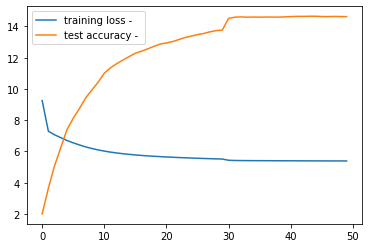

In [ ]:
#Обучаем
test_accs, top_k_accs, losses, best_model, best_acc, test_loader = train(args) 

print(test_accs, top_k_accs)
print("Maximum test set accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))

# plt.title(dataset.name)
plt.plot(losses, label="training loss" + " - ")
plt.plot(test_accs, label="test accuracy" + " - ")
plt.legend()
plt.show()

## Оценка


In [ ]:
# Сохраняем модель
torch.save(best_model.state_dict(), 'model')

In [ ]:
# Загружаем лучшую модель и выводим Hit@K accuracy
test_dataset = GraphDataset('./', 'test')
test_loader = pyg_data.DataLoader(test_dataset,
                                  batch_size=args.batch_size,
                                  shuffle=False,
                                  drop_last=True)

test(test_loader, best_model, is_validation=False, save_model_preds=True)

Processing...
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
Done!
100%|██████████| 507/507 [00:59<00:00,  8.57it/s]


(14.958579881656805, 46.72386587771203)

Hit@1 - 14.958579881656805, Hit@20 46.72386587771203

Модель правильно предсказывает следующий товар в сессии в 15 % случаях. Почти в 50% случаев правильный ответ попадает в топ 20 предсказаний модели. Модель показала хороший результат.